In [6]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

In [9]:
class DCNN(tf.keras.Model):
    def __init__(
        self,
        nb_filters = 50,
        FFN_units = 512,
        nb_classes = 2,
        dropout_rate = 0.1,
        name = "dcnn"
    ):
        super(DCNN,self).__init__(name=name)
        
        self.bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                                         trainable = False)
        self.bigram = layers.Conv1D(
            filters = nb_filters,
            kernel_size = 2,
            padding = 'valid',
            activation = 'relu'
        )
        self.trigram = layers.Conv1D(
            filters = nb_filters,
            kernel_size = 3,
            padding = 'valid',
            activation = 'relu'
        )
        self.fourgram = layers.Conv1D(
            filters = nb_filters,
            kernel_size = 4,
            padding = 'valid',
            activation = 'relu'
        )
            
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units = FFN_units, activation = 'relu')
        self.dropout = layers.Dropout(rate = dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
        else:
            self.last_dense = layers.Dense(units= nb_classes, activation = 'softmax')
    
    def embed_with_bert(self, all_tokens):
        _, embs = self.bert_layer([
            all_tokens[:, 0, :],
            all_tokens[:, 1, :],
            all_tokens[:, 2, :],
        ])
        return embs
    
    
    
    def call(self, inputs, training):
        x = self.embed_with_bert(inputs)

        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1,x_2,x_3], axis = -1)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [10]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [11]:
data =  pd.read_csv('/home/nilton/Arquivos/Softplan/Tutorials/Curso_BERT_Jonathan/bert_data/Base de dados sentimentos/training.1600000.processed.noemoticon.csv',
                       header = None,
                       names = cols,
                       engine='python',
                       encoding='latin-1')

In [12]:
data.drop(['id', 'date', 'query', 'user'],
             axis = 1, inplace = True)

In [13]:
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet,'lxml').get_text()
    tweet = re.sub(r"@[A-Za-z0-9]+",' ',tweet)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+",' ', tweet)
    tweet = re.sub(r"[^a-zA-Z.!?']", " ", tweet)
    tweet = re.sub(r" +", " ", tweet)
    return tweet

In [14]:
data_clean = [clean_tweet(tweet) for tweet in data.text]

In [15]:
data_labels = data.sentiment.values
data_labels[data_labels == 4] = 1
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1',
                               trainable = False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

In [17]:
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [19]:
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [20]:
def encode_sentence(sent):
    return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]
    
def get_ids(tokens):
    return tokenizer.convert_tokens_to_ids(tokens)

def get_mask(tokens):
    return np.char.not_equal(tokens,"[PAD]").astype(int)

In [21]:
def get_segments(tokens):
    seg_ids = []
    current_seg_id = 0
    for tok in tokens:
        seg_ids.append(current_seg_id)
        if tok == "[SEP]":
            current_seg_id = 1 - current_seg_id
    return seg_ids

In [22]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]

In [23]:
data_with_len = [
            [
                sent, data_labels[i], len(sent)
            ]
            for i, sent in enumerate(data_inputs)
]

In [24]:
## Data handling

In [25]:
min_tokens = 7
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [
            (
                [
                    get_ids(sent_lab[0]),
                    get_mask(sent_lab[0]),
                    get_segments(sent_lab[0])
                ],
                sent_lab[1]
            )
              for sent_lab in data_with_len if sent_lab[2] > min_tokens
]
BATCH_SIZE = 32
NB_BATCHES = len(sorted_all) // BATCH_SIZE
NB_BATCHES_TEST = NB_BATCHES // 10
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all, 
                                            output_types = (tf.int32, tf.int32))
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((3,None),()),
                                                                          padding_values = (0,0))

test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)


In [26]:
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 3
#
Dcnn = DCNN(
    nb_filters = NB_FILTERS,
    FFN_units = FFN_UNITS,
    nb_classes = NB_CLASSES,
    dropout_rate = DROPOUT_RATE
)
if  NB_CLASSES == 2:
    Dcnn.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
else:
    Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['sparse_categorical_accuracy'])

checkpoint_path = './'
ckpt = tf.train.Checkpoint(Dcnn= Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path,
                                 max_to_keep=1)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Lastest checkpoint restored')

class MyCustomCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        ckpt_manager.save()
        print(f"Checkpoint save at {checkpoint_path}")


In [27]:
history = Dcnn.fit(
    train_dataset,
    epochs = NB_EPOCHS,
    callbacks = [MyCustomCallBack()]
)

Epoch 1/3
  40623/Unknown - 21831s 537ms/step - loss: 0.3974 - accuracy: 0.8218Checkpoint save at ./
40623/40623 [==============================] - 21839s 537ms/step - loss: 0.3974 - accuracy: 0.8218
Epoch 2/3
40623/40623 [==============================] - 21353s 525ms/step - loss: 0.3759 - accuracy: 0.8338
Epoch 3/3
40623/40623 [==============================] - 21678s 533ms/step - loss: 0.3663 - accuracy: 0.8387


In [28]:
results = Dcnn.evaluate(test_dataset)
print(results)

4513/4513 [==============================] - 955s 211ms/step - loss: 0.3439 - accuracy: 0.8567
[0.34393003582954407, 0.8567264080047607]


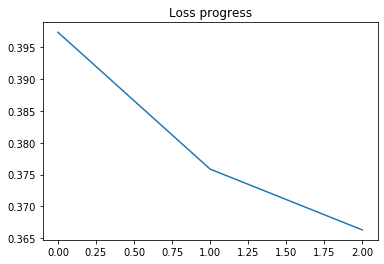

In [29]:
plt.plot(history.history['loss'])
plt.title('Loss progress');


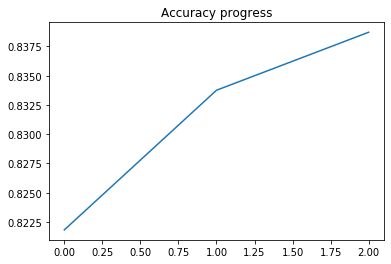

In [30]:
plt.plot(history.history['accuracy'])
plt.title('Accuracy progress');

In [32]:
def  get_prediction(sentence):
    tokens = encode_sentence(sentence)
    input_ids = get_ids(tokens)
    input_mask = get_mask(tokens)
    segment_ids = get_segments(tokens)
    inputs = tf.stack(
          [
           tf.cast(input_ids, dtype=tf.int32),
           tf.cast(input_mask, dtype=tf.int32),
           tf.cast(segment_ids, dtype=tf.int32),
          ], axis = 0
    )
    inputs = tf.expand_dims(inputs, 0)
    output = Dcnn(inputs, training=False)
    sentiment = math.floor(output*2)
    if sentiment == 0:
        print("Negative")
    elif sentiment == 1:
        print("Positive")
    else:
        print("Undermined")

In [33]:
get_prediction("I'm here to conquer NLP!!!")

Positive


In [34]:
get_prediction("I am sorry for your lost")

Negative


In [35]:
get_prediction('I am glad that the economy in this country is evolving fastly')

Positive


In [36]:
get_prediction("He is an idiot!")

Negative
